# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev1 toc-item"><a href="#Build-Graph" data-toc-modified-id="Build-Graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build Graph</a></div><div class="lev1 toc-item"><a href="#Model-Visualization" data-toc-modified-id="Model-Visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Visualization</a></div><div class="lev1 toc-item"><a href="#Train" data-toc-modified-id="Train-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train</a></div><div class="lev1 toc-item"><a href="#Predict" data-toc-modified-id="Predict-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Predict</a></div>

- **Neural Causal Reasoning Model**

# Load Data

In [1]:
import h5py

In [2]:
with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/embedding.h5', 'r') as fh:
    embedding = fh['embedding'][:] 

with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/data.h5', 'r') as fh:
    xc = fh['xc'][:] 
    xe = fh['xe'][:]
    s = fh['s'][:]
    xcTrain = fh['xcTrain'][:]
    xcVal = fh['xcVal'][:]
    xeTrain = fh['xeTrain'][:]
    xeVal = fh['xeVal'][:]
    yTrain = fh['yTrain'][:]
    yVal = fh['yVal'][:]

# Import Libraries

In [3]:
from keras.layers import Input, Embedding, Dense, Dropout, Flatten, dot
from keras.layers.noise import AlphaDropout
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


# Build Graph

In [49]:
def ncrm(num_layer=2, hidden_size=300, hidden_activation='relu', dropout_rate=0.2, seed=42, output_activation='sigmoid', loss='mse', optimizer='adam'):
    """
    Hyperparameters
    ----------
    :param num_layer: number of hidden layer
    :param hidden_size: sizes of hidden layer
    :param dropout_rate: dropout layer rate
    :param hidden_activation: activation function of hidden layer
    :param seed: random seed
    :param output_activation: activation function of output layer
    :param loss: loss function
    :param optimizer: optimize method
    
    Returns
    ----------
    Neural Causal Reasoning Model.
    """
    cw = Input(shape=(1,), name='CAUSE')
    cw_emb = Embedding(embedding.shape[0],
                       embedding.shape[-1],
                       weights=[embedding],
                       mask_zero=False,
                       input_length=1,
                       trainable=True,
                       name='CW_EMBEDDING')(cw)
    dense = Flatten(name='CW_FLATTEN')(cw_emb)
    for l in range(num_layer):
        dense = Dense(hidden_size, activation=hidden_activation, name='HIDDEN_%d' % (l+1))(dense)
        if hidden_activation == 'selu':
            dense = AlphaDropout(dropout_rate, seed=seed, name='DROPOUT_%d' % (l+1))(dense)
        else:
            dense = Dropout(dropout_rate, seed=seed, name='DROPOUT_%d' % (l+1))(dense)
    dense = Dense(300, activation=hidden_activation, name='HIDDEN_3')(dense)
    ew = Input(shape=(1,), name='EFFECT')
    ew_emb = Embedding(embedding.shape[0],
                       embedding.shape[-1],
                       weights=[embedding],
                       mask_zero=False,
                       input_length=1,
                       trainable=True,
                       name='EW_EMBEDDING')(ew)
    ew_emb = Flatten(name='EW_FLATTEN')(ew_emb)
    output = dot([dense, ew_emb], axes=-1, normalize=False, name='REASONING')
    output = Dense(1, activation=output_activation, name='OUTPUT')(output)
    model = Model(inputs=[cw, ew], outputs=output)
    model.compile(loss=loss, optimizer=optimizer)
    return model

# Model Visualization

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
CAUSE (InputLayer)               (None, 1)             0                                            
____________________________________________________________________________________________________
CW_EMBEDDING (Embedding)         (None, 1, 300)        837900      CAUSE[0][0]                      
____________________________________________________________________________________________________
CW_FLATTEN (Flatten)             (None, 300)           0           CW_EMBEDDING[0][0]               
____________________________________________________________________________________________________
HIDDEN_1 (Dense)                 (None, 300)           90300       CW_FLATTEN[0][0]                 
___________________________________________________________________________________________

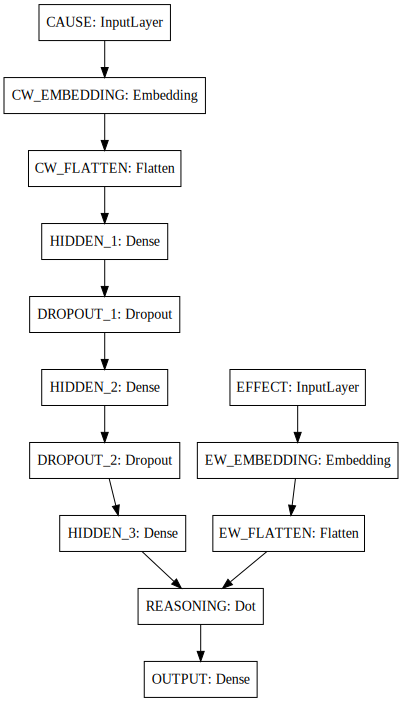

In [28]:
NCRM = ncrm()
NCRM.summary()
SVG(model_to_dot(NCRM).create(prog='dot', format='svg'))

# Train

In [115]:
filepath = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/train/cp_logs/selu+selu/weights.{epoch:03d}-{loss:.6f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
log_string = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/train/tb_logs/selu+selu'
tensorboard = TensorBoard(log_dir=log_string)
callbacks_list = [checkpoint, tensorboard]

In [116]:
NUM_LAYERS = 2
HIDDEN_SIZE = 300
HIDDEN_ACTIVATION = 'selu'
DROPOUT_RATE = 0.2
SEED = 42
OUTPUT_ACTIVATION = 'selu'
LOSS = 'mse'
OPTIMIZER = 'adam'

In [117]:
NCRM = ncrm(num_layer=NUM_LAYERS, 
            hidden_size=HIDDEN_SIZE, 
            hidden_activation=HIDDEN_ACTIVATION, 
            dropout_rate=DROPOUT_RATE, 
            seed=SEED, 
            output_activation=OUTPUT_ACTIVATION, 
            loss=LOSS, 
            optimizer=OPTIMIZER)

In [118]:
BATCH_SIZE = 1024
NUM_EPOCHS = 64

In [119]:
history = NCRM.fit([xcTrain, xeTrain],
                   yTrain,
                   batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS,
                   verbose=1,
                   callbacks=callbacks_list,
                   validation_data=([xcVal, xeVal], yVal),
                   shuffle=True)

Train on 1638134 samples, validate on 289083 samples
Epoch 1/64
1638134/1638134 [==============================] - 59s - loss: 0.9035 - val_loss: 0.8360
Epoch 2/64
1638134/1638134 [==============================] - 59s - loss: 0.7678 - val_loss: 0.8487
Epoch 3/64
1638134/1638134 [==============================] - 59s - loss: 0.7337 - val_loss: 1.0052
Epoch 4/64
1047552/1638134 [==================>...........] - ETA: 20s - loss: 0.7164

KeyboardInterrupt: 

In [120]:
filepath = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/train/cp_logs/relu+none/weights.{epoch:03d}-{loss:.6f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
log_string = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/train/tb_logs/relu+none'
tensorboard = TensorBoard(log_dir=log_string)
callbacks_list = [checkpoint, tensorboard]

In [51]:
BATCH_SIZE = 1024
NUM_EPOCHS = 12

In [52]:
history = NCRM.fit([xc, xe],
                   s,
                   batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS,
                   verbose=1,
                   callbacks=callbacks_list,
                   shuffle=True)

Epoch 1/12
1927217/1927217 [==============================] - 74s - loss: 0.8948    
Epoch 2/12
1927217/1927217 [==============================] - 74s - loss: 0.8500    
Epoch 3/12
1927217/1927217 [==============================] - 74s - loss: 0.8417    
Epoch 4/12
1927217/1927217 [==============================] - 71s - loss: 0.8375    
Epoch 5/12
1927217/1927217 [==============================] - 78s - loss: 0.8348    
Epoch 6/12
1927217/1927217 [==============================] - 77s - loss: 0.8324    
Epoch 7/12
1927217/1927217 [==============================] - 73s - loss: 0.8311    
Epoch 8/12
1927217/1927217 [==============================] - 69s - loss: 0.8297    
Epoch 9/12
1927217/1927217 [==============================] - 78s - loss: 0.8289    
Epoch 10/12
1927217/1927217 [==============================] - 76s - loss: 0.8277    
Epoch 11/12
1927217/1927217 [==============================] - 69s - loss: 0.8270    
Epoch 12/12
1927217/1927217 [==============================] - 

# Predict

In [50]:
import pickle

In [51]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/copa.pkl', 'rb') as fp:
    _, _, _, _, devcp1, devcp2, devLabel, testcp1, testcp2, testLabel = pickle.load(fp)
    
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/index.pkl', 'rb') as fp:
    word2index, index2word = pickle.load(fp)

In [52]:
NUM_LAYERS = 2
HIDDEN_SIZE = 600
HIDDEN_ACTIVATION = 'relu'
DROPOUT_RATE = 0.2
SEED = 42
OUTPUT_ACTIVATION = None
LOSS = 'mse'
OPTIMIZER = 'adam'

In [53]:
NCRM = ncrm(num_layer=NUM_LAYERS, 
            hidden_size=HIDDEN_SIZE, 
            hidden_activation=HIDDEN_ACTIVATION, 
            dropout_rate=DROPOUT_RATE, 
            seed=SEED, 
            output_activation=OUTPUT_ACTIVATION, 
            loss=LOSS, 
            optimizer=OPTIMIZER)

In [54]:
filename = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/train/cp_logs/600+3+alltrue/weights.137-0.227623.hdf5'
NCRM.load_weights(filename)

In [55]:
def CPMI(pairs, length=None, sp_score=False):
    """
    Compute causal-PMI score
    """
    score = []
    if length == None:
        length = len(pairs)
    for p in pairs:
        c = np.array([word2index[p[0]]])
        e = np.array([word2index[p[1]]])
        CS = NCRM.predict([c, e])[0][0]
        score.append(CS)
    if not sp_score:
        try:
            return sum(score) / length
        except:
            return 0
    else:
        return score

def accuracy(a1, a2, actu, length_mode=2016, show=True):
    """
    Calculate Accuracy
    """
    if length_mode == 2016:
        l1 = [len(set([i[0] for i in a1[n]]+[i[-1] for i in a1[n]])) for n in range(500)]
        l2 = [len(set([i[0] for i in a2[n]]+[i[-1] for i in a2[n]])) for n in range(500)]
        A1 = [CPMI(a1[i], length=l1[i]) for i in range(500)]
        A2 = [CPMI(a2[i], length=l2[i]) for i in range(500)]
    elif length_mode == 2017:
        A1 = [CPMI(p) for p in a1]
        A2 = [CPMI(p) for p in a2]
    pred = []
    for i in range(500):
        if A1[i] >= A2[i]:
            pred.append(1)
        elif A1[i] < A2[i]:
            pred.append(2)
        else:
            pred.append(0)
    S = sum([1 for i in range(len(pred)) if pred[i] == actu[i]])
    ACC = S / len(actu)
    print('Accuracy: \t%.9f' % (ACC))
    if show:
        error = []
        l1 = [len(set([i[0] for i in a1[n]]))+len(set([i[-1] for i in a1[n]])) for n in range(500)]
        l2 = [len(set([i[0] for i in a2[n]]))+len(set([i[-1] for i in a2[n]])) for n in range(500)]
        for i in range(500):
            s1 = []
            s2 = []
            print('————————————————————————————————————')
            print(str(i+1)+':')
            for p in a1[i]:
                print(p[0], p[1], CPMI([p], sp_score=True)[0])
                s1.append(CPMI([p], sp_score=True))
            print('------------------')
            for p in a2[i]:
                print(p[0], p[1], CPMI([p], sp_score=True)[0])
                s2.append(CPMI([p], sp_score=True))
            if length_mode == 2016:
                try:
                    S1 = sum(sum(s1, []))/l1[i]
                except:
                    S1 = 0
                try:
                    S2 = sum(sum(s2, []))/l2[i]
                except:
                    S2 = 0
            elif length_mode == 2017:
                S1 = sum(sum(s1, []))/len(a1[i])
                S2 = sum(sum(s2, []))/len(a2[i])
            print('S1:------'+str(S1))
            print('S2:------'+str(S2))
            if S1 >= S2:
                pre = '1'
            elif S1 < S2:
                pre = '2'
            else:
                pre = '0'
            print('Predict Answer: '+pre)
            print('Correct Answer: '+str(actu[i]))
            if pre != str(actu[i]):
                error.append(i+1)
        return pred, error
    else:
        return pred

In [58]:
p, e = accuracy(devcp1, devcp2, devLabel, length_mode=2016)

Accuracy: 	0.538000000
————————————————————————————————————
1:
sun body 1.88623
sun cast 2.00473
sun shadow 7.52228
rise body 0.454049
rise cast 0.519223
rise shadow 1.22231
------------------
cut body 0.632178
cut cast 1.15439
cut shadow 0.69804
S1:------2.72176368237
S2:------0.621152326465
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
2:
know tolerate 1.4339
know difficult 1.28785
know behavior 1.25614
go tolerate 1.10968
go difficult 1.12208
go behavior 0.950426
hard tolerate 0.893449
hard difficult 0.898089
hard behavior 0.626129
time tolerate 1.15508
time difficult 1.69451
time behavior 1.10094
------------------
feel tolerate 1.15237
feel difficult 0.745517
feel behavior 0.833658
take tolerate 1.22851
take difficult 1.30319
take behavior 1.04546
advantage tolerate 0.817477
advantage difficult 0.622598
advantage behavior 0.488656
kindness tolerate 0.683678
kindness difficult 0.297929
kindness behavior 0.245371
S1:------1.93260950702
S2:------1.352056886

irrigation construct 0.780749
------------------
farmland flood 1.52358
farmland occur 0.676088
need flood 1.10431
need occur 1.01065
irrigation flood 2.55891
irrigation occur 0.855703
S1:------2.78243973255
S2:------1.54585084915
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
24:
certain host 1.03925
certain cancel 0.345276
certain party 0.876045
------------------
worry host 0.562429
worry cancel 0.673031
worry party 0.645838
would host 1.07636
would cancel 1.02805
would party 1.2417
catch host 0.907243
catch cancel 0.251497
catch party 0.500257
S1:------0.56514300406
S2:------1.14773366849
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
25:
attract woman 0.48306
attract give 0.519393
attract man 0.673696
attract phone 0.136481
attract number 0.512212
------------------
repulse woman 0.146176
repulse give 0.295944
repulse man 0.400221
repulse phone 0.304571
repulse number 0.286913
S1:------0.387473742167
S2:------0.238970836004
Predi

star girl 1.61267
star make 0.904085
star wish 0.825763
S1:------1.62298876047
S2:------1.09370254278
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
47:
woman wrap 1.04467
woman towel 0.597569
shiver wrap 1.6745
shiver towel 7.998
get wrap 1.67238
get towel 1.58549
pool wrap 0.525636
pool towel 4.11506
------------------
woman pour 0.877995
woman lemonade 0.673593
shiver pour 3.1145
shiver lemonade 2.04455
get pour 1.55892
get lemonade 1.6379
pool pour 1.7068
pool lemonade 2.04421
S1:------3.20221833388
S2:------2.27641383807
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
48:
nurse bleed 1.08617
prepare bleed 0.558946
needle bleed 2.08546
injection bleed 2.15261
------------------
nurse tense 0.279495
prepare tense 0.729753
needle tense 0.971371
injection tense 1.01818
S1:------1.17663651705
S2:------0.599758970737
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
49:
fresh man 0.379319
fresh throw 1.32955
fresh

content away 0.546405
content weekend -0.0155677
S1:------1.66803961992
S2:------1.39752740661
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
69:
owner close 1.14203
help close 0.821255
customer close 1.0643
------------------
undergo close 0.300965
renovation close 1.71941
S1:------0.756898552179
S2:------0.673459152381
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
70:
play boy 2.35717
play tune 4.90775
play radio 2.79108
rock boy 1.62155
rock tune 3.63843
rock radio 2.5536
music boy 1.27593
music tune 7.87199
music radio 5.66752
------------------
come boy 2.05821
come tune 1.75837
come radio 1.46144
static boy 0.183798
static tune 0.392859
static radio 0.717574
S1:------5.44750328859
S2:------1.31445021629
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
71:
terrorist explode 1.73084
set explode 0.946374
------------------
terrorist deactivate 1.2295
set deactivate 2.51376
S1:------0.892403304577
S2:------1

pill woman 0.925587
pill awaken 1.05593
------------------
husband woman 1.55822
husband awaken 1.52448
snore woman 0.336969
snore awaken 7.32737
S1:------2.40421252251
S2:------2.68675860763
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
98:
woman remember 1.19511
woman take 0.931338
woman medication 1.02717
sense remember 1.21853
sense take 0.796399
sense medication 0.40724
pleasant remember 0.349591
pleasant take 0.395913
pleasant medication 0.533712
smell remember 0.743866
smell take 0.720452
smell medication 0.996911
------------------
woman remind 1.38731
woman childhood 1.30149
sense remind 1.33086
sense childhood 1.04446
pleasant remind 0.688736
pleasant childhood 0.164488
smell remind 1.02759
smell childhood 0.817857
S1:------1.33089056185
S2:------1.29379995664
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
99:
crowd bar 1.09816
crowd close 1.21714
------------------
3 bar 1.31863
3 close 1.17864
S1:------0.771767934163
S2:-

S2:------3.50356271267
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
121:
girl swerve 1.27441
go swerve 1.88848
hill swerve 3.49142
------------------
girl speed 0.090324
go speed 1.33595
hill speed 1.88004
S1:------1.6635748744
S2:------0.826578631997
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
122:
man confront 1.95932
cut confront 0.773537
front confront 1.18498
long confront 0.764298
line confront 0.384407
------------------
man smile 2.5865
cut smile 2.03491
front smile 1.32163
long smile 1.23496
line smile 0.63506
S1:------0.844423671563
S2:------1.3021770219
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
123:
travel inside 1.37186
travel go 1.57098
travel dark 0.0755503
tunnel inside 1.3298
tunnel go 1.28163
tunnel dark 0.727555
------------------
run inside 1.31013
run go 1.50479
run dark 0.581126
track inside 1.28919
track go 1.39045
track dark 0.218701
S1:------1.27147634029
S2:------1.258877730

navy sea 2.75206
bomb debris 3.20299
bomb sunk 1.14848
bomb sea 0.750322
S1:------2.19570985436
S2:------1.90523771048
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
147:
clean iron 0.950177
clean shirt 1.8959
------------------
wrinkle iron 1.05438
wrinkle shirt 3.59204
S1:------0.948691884677
S2:------1.54880555471
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
148:
girl lose 0.681891
girl balance 0.302881
feel lose 1.00191
feel balance 0.815755
dizzy lose 0.424905
dizzy balance 0.622809
------------------
girl stretch 0.88784
feel stretch 1.45284
dizzy stretch 1.1767
S1:------0.770030558109
S2:------0.879343003035
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
149:
go driver 1.42564
go pull 1.38806
go side 1.36111
go road 1.43716
intersection driver 3.9796
intersection pull 0.762806
intersection side 0.9751
intersection road 3.17023
------------------
notice driver 1.05728
notice pull 0.943144
notice side 

bird climb 0.7177
build boy 0.560159
build climb 2.13985
nest boy 0.356819
nest climb 2.34147
S1:------1.46003804207
S2:------1.38999868631
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
175:
carry squeak 0.755015
office squeak 1.47044
------------------
scoot squeak 15.6896
close squeak 0.959858
desk squeak 4.30692
S1:------0.741819798946
S2:------5.23910440505
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
176:
bedtime father 0.3998
bedtime shut 0.528841
bedtime television 0.717393
------------------
watch father 0.463999
watch shut 0.94338
watch television 4.85171
cartoon father 0.23604
cartoon shut 0.321906
cartoon television 1.24443
S1:------0.411508396268
S2:------1.61229336262
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
177:
go man 1.31802
go hold 1.3268
go breath 1.17958
underwater man 0.32329
underwater hold 0.714188
underwater breath 0.400953
------------------
tread man 0.481203
tread hold 0.584

Correct Answer: 2
————————————————————————————————————
200:
grab woman 0.393064
grab feel 0.520052
grab electric 0.175703
grab shock 0.746722
doorknob woman 0.116495
doorknob feel 0.322815
doorknob electric 1.29506
doorknob shock 1.88137
------------------
pound woman 0.630706
pound feel 0.522559
pound electric 0.635093
pound shock 0.510232
door woman 0.217358
door feel 0.471019
door electric 3.09826
door shock 0.288
S1:------0.908546109994
S2:------1.06220486263
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
201:
kiss man 1.61265
kiss lipstick 3.50561
kiss cheek 5.44289
------------------
make man 1.88188
make lipstick 4.62698
make cheek 1.18493
blush man 0.403474
blush lipstick 6.56838
blush cheek 9.58171
S1:------2.64028787613
S2:------4.84947048426
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
202:
sense jump 0.766664
sense instinctively 1.04969
sense fright 2.78561
someone jump 1.47451
someone instinctively 0.999166
someone frig

start take 1.33317
start away 1.47178
cry take 0.938581
cry away 0.984712
------------------
toddler give 0.659745
start give 1.18545
cry give 0.902523
S1:------1.20212979317
S2:------0.686930567026
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
223:
stranger star 0.451298
stranger blankly 0.99407
cry star 0.361374
cry blankly 1.04319
foreign star 0.289001
foreign blankly 0.975039
language star 0.355713
language blankly 1.07368
------------------
stranger stop 0.65466
stranger chat 1.03489
cry stop 2.08752
cry chat 0.914165
foreign stop 0.418792
foreign chat 0.222466
language stop 0.421399
language chat 0.706622
S1:------0.923893834154
S2:------1.07675108314
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
224:
uncover avoid 0.384152
incriminating avoid 0.75945
evidence avoid 0.893504
------------------
uncover blackmail 4.90813
incriminating blackmail 5.25154
evidence blackmail 1.77008
S1:------0.509276583791
S2:------2.98243674636
Pre

piano get 1.37558
piano stick 1.25398
S1:------2.61738234758
S2:------1.41777338982
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
248:
girl go 1.50977
girl see 1.46804
girl new 0.718799
girl film 1.30922
meet go 1.21189
meet see 1.23481
meet new 0.870775
meet film 0.651016
favorite go 1.38494
favorite see 1.37238
favorite new 0.538475
favorite film 1.91489
actor go 1.2705
actor see 1.29021
actor new 0.676174
actor film 6.37131
------------------
girl ask 1.35268
girl autograph 1.55253
meet ask 1.14232
meet autograph 2.41886
favorite ask 0.733634
favorite autograph 2.28213
actor ask 0.615991
actor autograph 2.13074
S1:------2.97414968163
S2:------2.03814780712
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
249:
cloudy vehicle 0.508322
cloudy travel 0.226444
cloudy slowly 1.45376
------------------
foggy vehicle 0.808164
foggy travel 0.849738
foggy slowly 1.72716
S1:------0.547132000327
S2:------0.846265718341
Predict Answer: 2
Correct

check calculation 0.989772
------------------
hasty man 0.536242
hasty make 0.322002
hasty error 0.908832
hasty calculation 1.31019
S1:------0.965568816662
S2:------0.61545368433
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
280:
recline woman -0.144482
recline eyeglass 16.1871
recline fog 4.18605
pool woman 0.320189
pool eyeglass 6.11063
pool fog 1.13541
------------------
enter woman 0.212606
enter eyeglass 1.92262
enter fog 0.804897
sauna woman 0.177505
sauna eyeglass 12.5086
sauna fog 3.21282
S1:------5.55898165703
S2:------3.76780848503
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
281:
shopper check 0.611947
shopper price 1.51692
shopper tag 0.568402
wonder check 1.75279
wonder price 0.473813
wonder tag 0.840079
cost check 0.494398
cost price 4.22127
cost tag 0.616961
item check 1.80038
item price 2.29071
item tag 2.78644
------------------
shopper decide 0.499284
shopper buy 2.13268
wonder decide 0.805142
wonder buy 0.868035


bill woman 0.627064
bill write 1.12981
bill check 0.946101
bill gas 0.845719
bill company 1.41939
S1:------1.88966131955
S2:------1.77875565737
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
302:
make woman 1.37444
make feel 1.67072
make reluctant 1.29713
make switch 1.32199
make career 1.40405
money woman 0.932641
money feel 1.00665
money reluctant 1.38672
money switch 0.841494
money career 0.931533
------------------
endure woman 0.388827
endure feel 0.359609
endure reluctant 1.16367
endure switch 0.14026
endure career 0.790654
stress woman 1.16701
stress feel 1.22043
stress reluctant 0.420309
stress switch 0.666429
stress career 0.351148
S1:------1.7381955811
S2:------0.952621417386
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
303:
call woman 1.1446
call file 1.32852
call restraining 1.14225
call order 0.986687
------------------
stalk woman 0.33424
stalk file 0.686316
stalk restraining 1.12662
stalk order 0.388106
S1:------0.920

customer bargain 1.95623
customer vendor 4.76946
think bargain 0.706118
think vendor 0.357015
souvenir bargain 2.93504
souvenir vendor 1.4207
overprice bargain 2.022
overprice vendor 1.51692
S1:------6.1386431853
S2:------2.61391296983
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
323:
discover scientist 1.45308
discover gain 0.514301
discover recognition 0.622364
new scientist 1.26025
new gain 1.38803
new recognition 1.36494
specie scientist 1.9974
specie gain -0.0327702
specie recognition 1.36121
------------------
receive scientist 0.603258
receive gain 0.779529
receive recognition 0.532071
tenure scientist 0.125546
tenure gain 0.407851
tenure recognition 0.903629
university scientist 0.955494
university gain 0.632573
university recognition 1.09436
S1:------1.654802531
S2:------1.0057191352
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
324:
car cross 1.79391
car road 7.62016
stop cross 1.30975
stop road 2.2793
crosswalk cross 1.2

sail diminish 0.522953
------------------
oil marine 4.12394
oil life 0.430293
oil diminish 1.56964
spill marine 5.23342
spill life 0.414103
spill diminish 1.0906
S1:------1.74916807413
S2:------2.57239878178
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
351:
run stick 1.47
run finger 1.09815
warm stick 0.493577
warm finger 1.10344
water stick 2.4602
water finger 0.848819
------------------
run vanish 1.29225
warm vanish 3.41893
water vanish 1.72788
S1:------1.49483761191
S2:------1.60976335406
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
352:
leave customer 0.725465
leave come 1.17687
leave boutique 0.820043
wallet customer 0.725958
wallet come 0.410913
wallet boutique 4.47145
home customer 1.16217
home come 2.2929
home boutique 1.27176
------------------
window customer 0.619844
window come 0.655322
window boutique 0.674728
display customer 0.704455
display come 0.620877
display boutique 1.16503
catch customer 0.246306
catch come

resolution class 0.628797
eat attend 0.595738
eat yoga 1.8418
eat class 0.662836
healthy attend 0.71654
healthy yoga 3.44614
healthy class 0.731866
diet attend 0.0324727
diet yoga 1.35996
diet class 0.421247
------------------
make buy 2.47277
make fruit 1.73235
make vegetable 1.9264
resolution buy 0.507327
resolution fruit 0.0219697
resolution vegetable 0.454409
eat buy 0.909512
eat fruit 8.30846
eat vegetable 7.42808
healthy buy 0.661077
healthy fruit 4.11749
healthy vegetable 3.86999
diet buy 0.494501
diet fruit 4.24912
diet vegetable 4.34371
S1:------2.01860953867
S2:------5.18714516982
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
378:
emotional patient 0.63318
emotional go 1.24838
emotional coma 1.56727
trauma patient 3.1671
trauma go 1.34978
trauma coma 3.0217
------------------
brain patient 3.45094
brain go 1.52678
brain coma 5.67205
damage patient 2.04211
damage go 1.82624
damage coma 2.62584
S1:------2.19748129845
S2:------3.42879002094
Predict Ans

break ask 0.846852
break stranger 1.10322
break time 0.882888
S1:------1.80058816075
S2:------1.93694299459
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
400:
arm soldier 3.89015
arm conceal 2.04727
arm brush 0.617614
rifle soldier 2.56017
rifle conceal 3.45531
rifle brush 0.83828
------------------
wear soldier 1.77764
wear conceal 0.739961
wear brush 2.55559
camouflage soldier 2.12692
camouflage conceal 5.68635
camouflage brush 2.3114
uniform soldier 3.16306
uniform conceal 1.87503
uniform brush 0.78543
S1:------2.68175874949
S2:------3.50356251995
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
401:
man toilet 1.44652
man fill 1.11809
turn toilet 1.09324
turn fill 0.602843
faucet toilet 3.74563
faucet fill 1.00356
------------------
man flow 0.567375
man spout 1.30931
turn flow 1.21459
turn spout 1.79372
faucet flow 0.828223
faucet spout 6.76367
S1:------1.80197634697
S2:------2.49537744522
Predict Answer: 2
Correct Answer: 2
—————

put woman 1.0987
put run 1.48529
put cold 1.25265
put water 1.21575
diamond woman 0.422195
diamond run 0.314774
diamond cold 0.0415817
diamond water 0.560926
ring woman 0.560112
ring run 0.520653
ring cold 0.769249
ring water 0.526089
S1:------1.27529141307
S2:------1.25256827899
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
421:
student correct 0.658566
misspell correct 0.811522
word correct 2.14392
------------------
student dismiss 1.15373
misspell dismiss 0.467438
word dismiss 0.338319
S1:------0.903501302004
S2:------0.489872515202
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
422:
heart regain 1.0884
heart composure 2.54009
heart fit 0.796435
heart anger 2.21281
pound regain 1.44874
pound composure 5.33054
pound fit 0.960406
pound anger 0.176432
------------------
take regain 1.64865
take composure 2.76972
take fit 1.46362
take anger 1.56521
deep regain 0.266682
deep composure 4.09017
deep fit 1.09838
deep anger 1.33464
breath

old gray 1.67017
------------------
man sell 0.875187
man belonging 1.7733
grow sell 0.788936
grow belonging 1.20357
old sell 1.58667
old belonging 2.12489
S1:------1.85665367047
S2:------1.67050981522
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
441:
friend cut 0.744266
friend half 0.888148
decide cut 1.04016
decide half 0.874065
share cut 0.607924
share half 0.635744
------------------
friend order 0.635366
friend fry 1.76605
decide order 1.39643
decide fry 0.925196
share order 0.821243
share fry 0.486205
S1:------0.958061850071
S2:------1.20609712005
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
442:
twist fizz 8.65296
cap fizz 1.1628
bottle fizz 4.8808
------------------
twist leak 0.96772
cap leak 3.97197
bottle leak 1.58807
S1:------3.67414051294
S2:------1.63194048405
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
443:
receive pair 0.735035
receive come 0.765205
receive scrutiny 0.524439
receive tea

get look 1.41184
get different 1.14514
hair man 1.38322
hair perceive 0.623541
hair look 2.05008
hair different 0.763898
cut man 0.653777
cut perceive 0.27957
cut look 0.839801
cut different 0.52031
------------------
wear man 1.68318
wear perceive 0.460744
wear look 1.76353
wear different 0.95145
bracelet man 0.533642
bracelet perceive 0.640517
bracelet look 0.51796
bracelet different 0.338719
S1:------1.70760789088
S2:------1.14829079807
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
467:
student make 0.966907
student excuse 1.45136
student tell 0.822308
forget make 0.965037
forget excuse 0.848031
forget tell 1.37765
assignment make 0.507877
assignment excuse 0.988423
assignment tell 0.485294
------------------
student promote 1.35089
student next 1.77335
student grade 8.49445
forget promote 0.223988
forget next 1.22632
forget grade 0.529217
assignment promote 0.701175
assignment next 1.17456
assignment grade 3.64823
S1:------1.40214724839
S2:------3.1870316

man owe 1.59123
man money 1.45398
win owe 1.5458
win money 2.3166
lottery owe 0.931411
lottery money 1.29483
S1:------1.61057963371
S2:------1.82677066326
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
491:
light drip 1.13429
------------------
light harden 1.15853
S1:------0.567143678665
S2:------0.57926517725
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
492:
spend sprain 0.743487
spend ankle 0.0187849
day sprain 2.17535
day ankle 0.613409
pool sprain 0.640393
pool ankle -0.528785
------------------
spend face 1.1491
spend get 1.37267
spend sunburn 0.336017
day face 0.42806
day get 1.26947
day sunburn 2.29996
pool face 0.666195
pool get 1.38033
pool sunburn 0.46202
S1:------0.732527017593
S2:------1.56063901385
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
493:
parallel man 0.30334
parallel receive 0.324387
parallel ticket 0.365147
park man 0.434375
park receive 0.716059
park ticket 2.72695
street man 0.9

In [59]:
p, e = accuracy(testcp1, testcp2, testLabel, length_mode=2016)

Accuracy: 	0.588000000
————————————————————————————————————
1:
fragile item 0.528947
fragile package 0.509281
fragile bubble 0.888132
fragile wrap 1.69437
------------------
small item 1.11047
small package 1.23978
small bubble 1.7967
small wrap 1.62022
S1:------0.724146354198
S2:------1.15343255997
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
2:
empty retrieve 2.7615
empty ticket 0.655106
empty stub 3.39561
pocket retrieve 0.548223
pocket ticket 0.487574
pocket stub 3.86949
------------------
empty find 0.559215
empty weapon 0.504991
pocket find 0.338068
pocket weapon 0.927789
S1:------2.34350163937
S2:------0.582516044378
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
3:
invade disappear 0.757142
------------------
invade eat 0.231529
invade wood 0.305701
S1:------0.378571122885
S2:------0.179076413314
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
4:
traveler check 0.819969
traveler passport 4.61011
reac

run manager 1.05279
public hire 1.32799
public campaign 2.00308
public manager 1.39845
office hire 1.92822
office campaign 1.60448
office manager 1.69054
------------------
woman testify 1.22541
woman court 0.808591
decide testify 0.925929
decide court 1.43149
run testify 0.36245
run court 1.23037
public testify 1.33348
public court 1.73128
office testify 1.13022
office court 1.23578
S1:------2.58228841424
S2:------1.63071342877
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
23:
man pack 0.957338
man warm 0.770415
man clothing 1.26725
anticipate pack 0.35164
anticipate warm 0.395388
anticipate clothing 0.603774
cold pack 1.33601
cold warm 4.94577
cold clothing 2.37845
weather pack 1.22509
weather warm 3.09747
weather clothing 1.55933
trip pack 1.72332
trip warm 0.248863
trip clothing 1.01266
------------------
man travel 0.7676
man big 1.5872
anticipate travel 0.543616
anticipate big 0.440551
cold travel 1.09309
cold big 0.769891
weather travel 3.95486
weather

————————————————————————————————————
49:
search cashier -0.226804
search open 1.07442
search cash 0.662898
search register 0.693386
wallet cashier 7.91207
wallet open 0.280682
wallet cash 1.07138
wallet register 0.577826
------------------
hand cashier 0.482108
hand open 0.99992
hand cash 0.914422
hand register 0.562492
money cashier 5.44372
money open 0.808283
money cash 5.09732
money register 0.75653
S1:------2.00764417648
S2:------2.5107995222
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
50:
street people 1.13147
street give 0.635469
street change 0.358918
musician people 0.2715
musician give 0.585022
musician change 0.265969
attract people 0.559371
attract give 0.519393
attract change 0.482242
------------------
street send 0.398526
street away 0.914805
musician send 0.412238
musician away 0.345648
attract send 0.35563
attract away 0.548243
S1:------0.801559329033
S2:------0.595018053055
Predict Answer: 1
Correct Answer: 1
———————————————————————————————

go sunscreen 1.91233
beach man 0.0394012
beach put 0.394535
beach sunscreen 2.94545
S1:------1.24852237701
S2:------1.60146074295
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
74:
prove retract 1.71342
------------------
prove individual 0.721982
prove accept 1.18569
S1:------0.856709122658
S2:------0.635889172554
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
75:
go fan 1.43144
go boo 1.49754
overtime fan 0.664769
overtime boo 2.80799
------------------
referee fan 2.07377
referee boo 3.4195
make fan 2.08336
make boo 1.66683
bad fan 1.41452
bad boo 2.63205
call fan 1.22409
call boo 1.42777
S1:------1.60043376684
S2:------2.65698313713
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
76:
enter shut 0.981386
combination shut 0.537784
------------------
enter pop 1.27961
enter open 1.454
combination pop 0.3573
combination open 0.475438
S1:------0.50639017423
S2:------0.891585439444
Predict Answer: 2
Correct Answ

hungry tank 0.409092
------------------
dead fish 0.848955
dead float 0.750618
dead surface 0.614852
dead tank 1.1126
S1:------0.663655877113
S2:------0.665405976772
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
105:
cold man 0.397996
cold voice 1.01145
cold sound 0.506186
cold hoarse 1.56263
------------------
quit man 0.689666
quit voice 0.357366
quit sound 0.488847
quit hoarse 6.16276
smoking man 1.52224
smoking voice 1.4614
smoking sound 0.715197
smoking hoarse 6.00672
S1:------0.695652616024
S2:------2.90069845319
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
106:
arrive door 1.08042
arrive open 0.803485
designate door 0.0809691
designate open 0.437712
------------------
get door 1.81166
get open 1.35006
stick door 1.05134
stick open 0.71807
S1:------0.600646987557
S2:------1.23278108239
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
107:
lie teenager 0.756194
lie sneak 1.44708
lie house 0.429669
-----

rain inside 1.44489
pour dash 0.0915322
pour get 1.32798
pour inside 1.25609
S1:------2.03792381287
S2:------1.33261162043
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
127:
elevator building 2.29212
elevator evacuate 4.53179
stop building 0.78446
stop evacuate 1.03509
function building 0.558733
function evacuate -0.272046
------------------
fire building 6.39233
fire evacuate 11.1251
alarm building 1.11707
alarm evacuate 3.10745
go building 1.17877
go evacuate 1.05107
S1:------1.78602809906
S2:------4.79435584545
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
128:
resent buy 0.301726
resent beer 0.95964
alcoholism buy 0.071375
alcoholism beer 0.511108
------------------
resent kick 0.685033
resent house 0.280948
alcoholism kick 0.523999
alcoholism house 0.453459
S1:------0.460962086916
S2:------0.48585972935
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
129:
secretary lawyer 0.569395
secretary take 0.45769

traffic show 0.515467
------------------
get couple 1.35294
get leave 1.35311
get early 1.16378
get show 1.19355
direction couple 0.602568
direction leave 0.619816
direction early 0.511194
direction show 0.594766
S1:------0.804062997301
S2:------1.23195196191
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
149:
woman boss 0.867019
woman praise 1.53346
stay boss 1.55108
stay praise 0.479631
home boss 3.27233
home praise 0.430195
work boss 5.64847
work praise 1.84219
------------------
woman coworker 1.21321
woman cover 0.892011
stay coworker 1.05471
stay cover 0.976289
home coworker 1.30801
home cover 1.57382
work coworker 1.27791
work cover 1.86392
S1:------2.60406172276
S2:------1.69331290325
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
150:
support man 0.838308
support sign 1.06708
support activist 3.44968
support petition 1.93219
cause man 0.961768
cause sign 1.16844
cause activist 0.816097
cause petition 1.16318
-----------------

speak hang 1.48383
supervisor associate 0.41047
supervisor hang 0.46616
------------------
provide associate 1.32756
provide hang 0.509935
identification associate 0.672664
identification hang 0.444197
number associate 1.29294
number hang 0.8907
S1:------0.943348634243
S2:------1.02759834528
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
178:
wind doorbell 8.41318
wind ring 0.871139
blow doorbell 6.76542
blow ring 1.03515
open doorbell 5.43179
open ring 0.601172
window doorbell 9.49445
window ring 0.604958
------------------
wind curtain 3.5987
wind shudder 1.83825
blow curtain 2.24119
blow shudder 0.973913
open curtain 1.86021
open shudder 0.602506
window curtain 3.61433
window shudder 1.21578
S1:------5.53620778521
S2:------2.65747915705
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
179:
unplug electricity 2.03776
unplug house 0.640346
unplug shut 1.75875
lamp electricity 2.97071
lamp house 0.413215
lamp shut 1.40621
--------------

long boy 1.04979
long finger 1.55992
long become 1.25329
long pruny 0.869101
shower boy 1.37317
shower finger 9.23872e-05
shower become 1.27124
shower pruny 0.859584
------------------
lather boy 0.780181
lather finger 2.40094
lather become 2.12883
lather pruny 0.755888
hand boy 0.968796
hand finger 3.08789
hand become 1.24765
hand pruny 0.948779
soap boy 1.04258
soap finger 0.879007
soap become 1.21771
soap pruny 0.973998
S1:------2.01186606714
S2:------2.34746382918
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
202:
taste spit 1.17332
sour spit 2.18231
------------------
mouth spit 3.17396
dry spit 1.7526
S1:------1.11854306857
S2:------1.642187198
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
203:
miss early 0.960583
bus early 0.479695
------------------
miss late 1.55408
bus late 1.00989
S1:------0.480092595021
S2:------0.85465669632
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
204:
collide speed 1.10

discover divorce 0.810125
wife file 0.855615
wife divorce 3.44865
affair file 0.651387
affair divorce 2.82803
S1:------0.866162608067
S2:------2.32798354824
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
228:
girl bounce 1.13998
drop bounce 2.26244
rubber bounce 3.69461
------------------
girl glow 0.241474
drop glow 0.753762
rubber glow 0.797389
S1:------1.77425858378
S2:------0.448156133294
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
229:
girl guess 1.77407
make guess 2.34979
mistake guess 0.647339
exam guess 0.409871
------------------
girl erase 0.64901
make erase 1.12283
mistake erase 2.38372
exam erase 0.542591
S1:------1.03621432781
S2:------0.939629149437
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
230:
player catch 1.51386
player pass 1.09122
tackle catch 0.802822
tackle pass 0.509069
------------------
player hit 2.44187
player ground 0.949072
tackle hit 0.694513
tackle ground 0.649662
S1:----

recognize crossing 0.877262
recognize guard 0.535737
recognize blow 0.304566
recognize whistle 0.235297
recognize child 0.919965
neighborhood crossing 2.53539
neighborhood guard 0.612177
neighborhood blow 0.32566
neighborhood whistle 1.54443
neighborhood child 0.82267
S1:------3.27650337666
S2:------1.24473628828
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
256:
tell roll 0.811161
tell eye 1.14621
tell friend 2.08854
truth roll 0.0865486
truth eye 0.718565
truth friend 1.06229
------------------
make roll 2.52972
make eye 1.54861
make friend 2.09027
sarcastic roll 0.226882
sarcastic eye 0.56814
sarcastic friend 0.718171
remark roll 0.515753
remark eye 0.168132
remark friend 0.491521
S1:------1.1826617837
S2:------1.47620114187
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
257:
car strand 2.95331
car road 7.62016
run strand 0.592377
run road 1.41129
gas strand 1.30997
gas road 0.941581
------------------
car pick 1.54164
car hitchhi

————————————————————————————————————
274:
hand man 0.925947
hand drop 1.06755
shake man 0.56763
shake drop 0.65171
------------------
lick man 0.693135
lick drop 0.464318
S1:------0.803210034966
S2:------0.38581776619
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
275:
ceo dissolve 0.376429
resign dissolve 1.07439
------------------
ceo find 0.197214
ceo replacement 0.100548
resign find 0.248028
resign replacement 1.10347
S1:------0.483604749044
S2:------0.412314981222
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
276:
arrive take 1.15042
arrive seat 2.20476
arrive back 1.06222
arrive row 0.974427
late take 1.03634
late seat 0.853532
late back 1.06929
late row 1.22127
lecture take 0.653603
lecture seat 0.513659
lecture back 0.321219
lecture row 0.67655
------------------
arrive approach 0.239809
arrive podium 1.65442
late approach 0.668722
late podium 2.34489
lecture approach 0.730752
lecture podium 4.99434
S1:------1.67675550495
S2:

repellent get 2.30805
repellent squash 6.30286
------------------
step get 1.16819
step squash 0.805421
S1:------3.01593866944
S2:------0.657871723175
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
299:
wake open 0.679553
wake eye 0.772251
------------------
relax open 0.443082
relax eye 0.689338
S1:------0.483934640884
S2:------0.37747357289
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
300:
neighbor turn 0.614705
music turn 1.27846
blare turn 0.589183
------------------
neighbor borrow 0.37682
neighbor cd 0.30951
music borrow 1.45976
music cd 8.22742
blare borrow 3.03347
blare cd 0.493508
S1:------0.620586186647
S2:------2.78009823561
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
301:
frugal man 0.451238
frugal family 0.518251
frugal live 0.445679
frugal poverty 1.43446
earning man 0.756216
earning family 0.71562
earning live 0.663641
earning poverty 0.731537
------------------
earn man 0.574262
earn fami

————————————————————————————————————
322:
girl sit 1.64731
whisper sit 0.767156
back sit 2.98552
forth sit 1.2993
------------------
girl feel 1.37193
girl leave 1.03866
whisper feel 0.405795
whisper leave 0.368297
back feel 1.10188
back leave 1.64881
forth feel 0.438388
forth leave 0.370709
S1:------1.3398570776
S2:------1.12407687306
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
323:
child spring 0.773462
child back 1.13607
child air 0.477567
land spring 1.25969
land back 0.745201
land air 0.979686
trampoline spring 2.05518
trampoline back 0.256103
trampoline air -0.0573881
------------------
child decide 1.8642
child try 1.22
child flip 1.05089
land decide 0.602416
land try 0.406228
land flip 1.23734
trampoline decide 0.0932851
trampoline try 0.1785
trampoline flip 4.07758
S1:------1.27092940609
S2:------1.78840653102
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
324:
deposit deliver 0.383055
mailbox deliver 1.88737
-------------

welcome go 1.09759
welcome dinner 1.19852
S1:------3.94842632328
S2:------4.11662186895
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
343:
girl start 1.16486
girl hide 1.66957
catch start 1.01318
catch hide 0.657052
brother start 0.69375
brother hide 0.917175
read start 1.51635
read hide 0.97076
------------------
girl get 1.45904
girl new 0.718799
catch get 1.30859
catch new 0.648745
brother get 1.321
brother new 0.590778
read get 1.77552
read new 0.972346
S1:------1.43378186226
S2:------1.46580253045
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
344:
woman work 0.975898
woman overtime 0.175258
short work 1.22651
short overtime 2.15284
money work 1.56192
money overtime 1.839
rent work 0.603616
rent overtime 0.0433229
------------------
woman quit 1.61935
woman job 1.09074
short quit 0.97194
short job 1.55851
money quit 2.46161
money job 2.11572
rent quit 0.56301
rent job 0.694171
S1:------1.42972713709
S2:------1.84584140778
Predic

receive bankruptcy 1.57553
alimony woman 0.277263
alimony declare 0.368258
alimony bankruptcy 3.32184
payment woman 0.256265
payment declare 0.94101
payment bankruptcy 6.02948
------------------
acquire woman 0.494014
acquire declare 0.623362
acquire bankruptcy 0.736579
massive woman 0.468592
massive declare 1.27074
massive bankruptcy 1.51058
debt woman 0.335256
debt declare 0.992908
debt bankruptcy 6.28422
S1:------2.37455270688
S2:------2.119374156
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
370:
light wonder 1.1666
friend wonder 1.86909
apartment wonder 0.617514
------------------
light decide 0.661341
light pay 0.289711
light visit 0.346418
friend decide 1.4123
friend pay 0.938595
friend visit 1.39795
apartment decide 0.681815
apartment pay 1.11522
apartment visit 1.27662
S1:------0.913299784064
S2:------1.35332989693
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
371:
put petal 0.942921
put come 1.23609
nose petal 1.53413
nose

make friend 2.09027
make flip 1.88745
make coin 1.46602
fair friend 0.502611
fair flip 0.480637
fair coin 0.608953
decision friend 0.449804
decision flip 0.654455
decision coin 0.411943
S1:------0.721268427372
S2:------1.42535914977
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
400:
timer unload 3.5592
timer grocery 1.42902
timer refrigerator 2.68627
kitchen unload 2.19628
kitchen grocery 2.83252
kitchen refrigerator 2.88769
go unload 1.72297
go grocery 1.59014
go refrigerator 1.89449
------------------
timer take 0.366033
timer pizza 0.69456
timer oven 2.62726
kitchen take 0.45534
kitchen pizza 3.06878
kitchen oven 5.08101
go take 1.29373
go pizza 1.79193
go oven 1.73046
S1:------3.46643102169
S2:------2.85151625176
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
401:
woman slack 1.41042
set slack 0.908928
ambitious slack 2.7451
goal slack 1.12918
------------------
woman work 0.975898
woman hard 1.16482
set work 1.18917
set hard 1.1

audience project 0.681701
audience clearly 1.24072
audience auditorium 4.4984
------------------
speak man 1.46284
speak voice 3.17446
speak project 0.47252
speak clearly 1.37559
speak auditorium 4.51369
microphone man 0.159632
microphone voice 1.53389
microphone project 0.196172
microphone clearly 1.17247
microphone auditorium 10.6433
S1:------3.25142985582
S2:------3.52922358257
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
420:
toss sunk 1.12455
toss bottom 0.505369
fountain sunk 1.19619
fountain bottom 1.35255
water sunk 1.508
water bottom 3.38389
------------------
toss break 0.471316
toss half 0.652794
fountain break 0.150277
fountain half 0.481004
water break 1.29699
water half 1.45641
S1:------1.81411010027
S2:------0.901757746935
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
421:
hit go 1.70088
------------------
hit retreat 1.37966
hit back 1.55119
S1:------0.85044157505
S2:------0.976947625478
Predict Answer: 2
Correct An

business employee 2.9085
succeed fire 0.571603
succeed employee 0.441926
------------------
woman become 1.38072
woman wealthy 1.1753
business become 1.48512
business wealthy 1.61028
succeed become 1.06547
succeed wealthy 0.935441
S1:------1.19824106693
S2:------1.53046587706
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
450:
bell student 0.336755
bell exit 0.535215
bell classroom 0.80395
ring student 0.267409
ring exit 0.784286
ring classroom 0.0458866
------------------
teacher student 8.23829
teacher exit 0.904183
teacher classroom 8.53734
assign student 1.2376
assign exit 1.01615
assign classroom 1.07132
homework student 3.07582
homework exit 0.406797
homework classroom 3.23985
S1:------0.554700255394
S2:------4.62122585376
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
451:
woman express 1.0876
woman skepticism 2.1842
claim express 0.897191
claim skepticism 2.01224
see express 1.07978
see skepticism 1.1961
ghost express 0.468594

wreck encounter 0.319505
wreck pirate 1.35319
S1:------1.15570743879
S2:------1.32822667062
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
473:
boy solve 0.378737
feel solve 1.11085
stump solve 0.74432
------------------
boy request 0.343031
boy hint 0.760899
feel request 1.78051
feel hint 1.02173
stump request 0.455545
stump hint 1.80351
S1:------0.558476999402
S2:------1.23304336667
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
474:
ring hang 0.962099
------------------
ring pick 0.732672
S1:------0.481049656868
S2:------0.366335839033
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
475:
woman hug 1.63034
star hug 0.661293
------------------
woman feel 1.35527
woman uncomfortable 1.93439
star feel 0.636937
star uncomfortable 0.419563
S1:------0.763875961304
S2:------1.08653913438
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
476:
take group 1.16746
take leave 1.83983
take museum 1

In [61]:
filename = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/train/cp_logs/600+3+alltrue/weights.507-0.191474.hdf5'
NCRM.load_weights(filename)

In [64]:
p, e = accuracy(devcp1, devcp2, devLabel, length_mode=2017)

Accuracy: 	0.540000000
————————————————————————————————————
1:
sun body 1.8427
sun cast 1.92429
sun shadow 7.31584
rise body 0.450412
rise cast 0.402629
rise shadow 1.31315
------------------
cut body 0.527582
cut cast 0.857829
cut shadow 0.794007
S1:------2.20816913247
S2:------0.7264726758
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
2:
know tolerate 1.60308
know difficult 1.31662
know behavior 1.3441
go tolerate 1.421
go difficult 1.4972
go behavior 1.3238
hard tolerate 1.0648
hard difficult 0.967785
hard behavior 0.544973
time tolerate 1.17187
time difficult 1.76368
time behavior 1.16282
------------------
feel tolerate 1.22401
feel difficult 0.740342
feel behavior 0.808695
take tolerate 1.05585
take difficult 1.31015
take behavior 0.958845
advantage tolerate 0.633892
advantage difficult 0.599405
advantage behavior 0.51713
kindness tolerate 0.811398
kindness difficult 0.187456
kindness behavior 0.177597
S1:------1.26514432828
S2:------0.752063905199
Pred

look ask 1.62246
look like 2.74947
look sushi 2.28439
gentleman ask 0.318269
gentleman like 0.413879
gentleman sushi 1.70249
S1:------1.00768244863
S2:------1.29950277408
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
23:
farmland canal 1.72027
farmland construct 1.12337
need canal 1.38108
need construct 1.41649
irrigation canal 6.82685
irrigation construct 0.693164
------------------
farmland flood 1.4774
farmland occur 0.533429
need flood 1.52769
need occur 1.27948
irrigation flood 2.20212
irrigation occur 0.686818
S1:------2.19353799025
S2:------1.28449024757
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
24:
certain host 1.06589
certain cancel 0.412871
certain party 0.83595
------------------
worry host 0.482229
worry cancel 0.672023
worry party 0.566728
would host 1.39442
would cancel 1.50604
would party 1.67941
catch host 0.93308
catch cancel 0.297445
catch party 0.394657
S1:------0.771571735541
S2:------0.880670189857
Predict A

------------------
stale man 0.257648
stale throw 0.528942
stale bread 5.07477
S1:------2.07928615808
S2:------1.95378559828
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
50:
pillow child 0.449142
pillow knock 0.461784
pillow lamp 1.23937
fight child 0.8672
fight knock 1.98383
fight lamp -0.00505102
------------------
jump child 0.209261
jump knock 1.88785
jump lamp 0.218191
bed child 0.851748
bed knock 1.23125
bed lamp 1.56749
S1:------0.832713713249
S2:------0.994298388561
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
51:
thirsty drink 5.21714
thirsty water 4.36587
thirsty fountain 3.28134
------------------
feel drink 1.73752
feel water 0.725288
feel fountain 1.48779
nauseous drink 3.32676
nauseous water 1.07739
nauseous fountain 8.31133
S1:------4.28811772664
S2:------2.77767787377
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
52:
homeowner build 0.630976
homeowner fence 3.45455
homeowner property 1.94

vow detail 0.362713
protect struggle 0.438947
protect recall 0.358095
protect detail 0.689991
identity struggle 0.9661
identity recall 0.333805
identity detail 0.481925
------------------
authority withhold 1.97518
authority name 0.602745
authority public 1.32953
vow withhold 1.81991
vow name 0.223148
vow public 0.164683
protect withhold 2.09944
protect name 0.545187
protect public 1.18843
identity withhold 1.4158
identity name 0.708202
identity public 0.970096
S1:------0.564053451022
S2:------1.08686284224
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
74:
buy man 0.638372
buy clothe 1.99804
buy fit 1.39782
buy loosely 1.0503
sale man 0.166115
sale clothe 1.16448
sale fit 0.774717
sale loosely 0.965511
------------------
lose man 1.13659
lose clothe 1.51784
lose fit 0.543311
lose loosely 1.06652
weight man 0.660167
weight clothe 0.897485
weight fit 1.8461
weight loosely 1.3227
S1:------1.01941974461
S2:------1.12384162843
Predict Answer: 2
Correct Answer: 2
—

lay vacation 0.332055
------------------
receive woman 0.746654
receive take 1.03699
receive family 1.20444
receive vacation 0.697263
salary woman 0.251629
salary take 0.275202
salary family 0.357339
salary vacation 0.204132
bonus woman 0.213574
bonus take 0.383089
bonus family 0.229002
bonus vacation 0.177482
S1:------1.26407530904
S2:------0.481399198373
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
97:
take woman 1.42773
take awaken 1.64616
sleep woman 0.876034
sleep awaken 6.40925
pill woman 0.896636
pill awaken 1.283
------------------
husband woman 1.6815
husband awaken 1.21705
snore woman 0.333135
snore awaken 7.82078
S1:------2.08979978164
S2:------2.76311689615
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
98:
woman remember 1.24397
woman take 0.944632
woman medication 0.908031
sense remember 1.17438
sense take 0.751226
sense medication 0.30285
pleasant remember 0.368724
pleasant take 0.340354
pleasant medication 0.560371
s

————————————————————————————————————
122:
man confront 1.99379
cut confront 0.949188
front confront 1.68824
long confront 0.788622
line confront 0.588199
------------------
man smile 2.23166
cut smile 1.89262
front smile 1.67444
long smile 1.42545
line smile 0.543094
S1:------1.20160928965
S2:------1.55345313549
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
123:
travel inside 1.19358
travel go 1.32331
travel dark 0.333986
tunnel inside 1.22671
tunnel go 1.26204
tunnel dark 0.0813193
------------------
run inside 1.19518
run go 1.32013
run dark 0.580117
track inside 1.17923
track go 1.26416
track dark 0.246814
S1:------0.903490334749
S2:------0.964272260666
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
124:
man feel 1.33946
man awe 3.38546
contemplate feel 0.452961
contemplate awe 2.74162
painting feel 0.302681
painting awe 2.66466
------------------
man collapse 1.10651
contemplate collapse 0.254481
painting collapse 0.393665
S1:---

151:
get child 1.50877
get catch 2.0029
get life 1.60168
get threaten 1.55342
get illness 1.46305
vaccinate child 1.9559
vaccinate catch 0.63541
vaccinate life 0.348116
vaccinate threaten 0.714432
vaccinate illness 2.39602
------------------
adopt child 1.43925
adopt catch 0.147357
adopt life 0.473989
adopt threaten 0.682745
adopt illness 0.399258
S1:------1.41796985269
S2:------0.628519833088
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
152:
find film 0.704285
find begin 0.778305
empty film 0.24469
empty begin 0.456194
seat film 0.548119
seat begin 0.58788
theatre film 4.24911
theatre begin 0.416444
------------------
find sit 1.02436
empty sit 1.09638
seat sit 3.17113
theatre sit 0.74126
S1:------0.998128429055
S2:------1.50828391314
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
153:
parent teach 3.56665
parent ride 1.14356
parent bike 0.71076
recognize teach 1.30397
recognize ride 0.35981
recognize bike 0.314626
daughter teach 0

underwater hold 0.551622
underwater breath 0.229201
------------------
tread man 0.187808
tread hold 0.359362
tread breath 1.78679
water man 0.357973
water hold 1.07618
water breath 1.32141
S1:------0.966777384281
S2:------0.848253240188
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
178:
clumsily run 1.03157
clumsily away 1.03811
bump run 0.684574
bump away 0.66807
stranger run 0.526891
stranger away 0.59469
------------------
clumsily apologize 2.65616
bump apologize 0.834495
stranger apologize 1.71751
S1:------0.75731643041
S2:------1.73605459929
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
179:
captain boat 2.98206
captain capsize 3.36313
raise boat 0.735503
raise capsize 0.898544
sail boat 4.65762
sail capsize 3.89783
------------------
catch boat 2.48423
catch capsize 3.06441
hurricane boat 2.24789
hurricane capsize 7.09699
S1:------2.75578334928
S2:------3.72337901592
Predict Answer: 2
Correct Answer: 2
——————————————————————

grab electric 0.365107
grab shock 0.849876
doorknob woman 0.225093
doorknob feel 0.0617354
doorknob electric 0.651798
doorknob shock 1.6369
------------------
pound woman 0.63142
pound feel 0.507809
pound electric 0.284841
pound shock 0.358283
door woman 0.616405
door feel 0.391942
door electric 3.12786
door shock 0.194613
S1:------0.591910012066
S2:------0.764146387577
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
201:
kiss man 1.29311
kiss lipstick 2.71438
kiss cheek 4.18199
------------------
make man 1.92004
make lipstick 4.26529
make cheek 1.55796
blush man 0.637446
blush lipstick 3.4287
blush cheek 7.52671
S1:------2.72982943058
S2:------3.22269010544
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
202:
sense jump 0.773447
sense instinctively 1.02625
sense fright 2.97969
someone jump 1.91644
someone instinctively 0.986052
someone fright 1.9613
approach jump 0.751786
approach instinctively 1.00517
approach fright 2.23599
behind j

demonstrate lap 0.14574
proper put 0.561585
proper lap 1.39794
etiquette put 0.306605
etiquette lap 3.69615
S1:------1.02314319909
S2:------1.35614612699
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
220:
flash confiscate 1.45617
------------------
flash let 4.36374
flash enter 0.648322
flash crime 0.543862
flash scene 1.05586
S1:------1.45617318153
S2:------1.65294602513
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
221:
want eat 1.89307
want cookie 1.94512
want bake 1.60559
make eat 2.21175
make cookie 4.09003
make bake 3.59744
happy eat 1.1266
happy cookie 1.42356
happy bake 0.808634
------------------
want pick 1.87679
want flower 2.091
make pick 1.92368
make flower 2.38306
happy pick 0.944848
happy flower 1.58682
S1:------2.07797797521
S2:------1.80103238424
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
222:
toddler take 0.69662
toddler away 0.60884
start take 1.33364
start away 1.54175
cry take 0.899

tell conversation 1.86152
funny get 1.18904
funny distract 0.820993
funny conversation 2.39577
story get 1.26258
story distract 1.42269
story conversation 1.32194
S1:------1.5935249726
S2:------1.36249742905
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
242:
put power 1.03828
coin power 0.141944
washing power 0.267151
laundromat power 0.168967
------------------
put run 1.4324
put laundry 2.1395
put detergent 1.4528
coin run 0.334416
coin laundry 1.21623
coin detergent 2.95326
washing run 0.851231
washing laundry 2.958
washing detergent 26.6189
laundromat run 0.880912
laundromat laundry 4.66862
laundromat detergent 27.9894
S1:------0.404085189104
S2:------6.12463823458
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
243:
forecast family 0.246421
forecast postpone 3.51945
forecast barbeque 5.63401
call family 1.10136
call postpone 0.843426
call barbeque 0.939313
storm family 0.474714
storm postpone 7.708
storm barbeque 1.63533
--------

Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
271:
hiking foot 0.496675
hiking blister 1.22238
------------------
swimming foot 1.72694
swimming blister 1.00595
S1:------0.859526470304
S2:------1.36644732952
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
272:
woman send 0.501616
woman greeting 3.6281
woman card 0.656072
betray send 0.0984911
betray greeting 7.00039
betray card 0.546931
------------------
woman cut 0.635765
woman contact 0.621192
betray cut 0.128508
betray contact 0.0217515
S1:------2.07193386555
S2:------0.351804241538
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
273:
catch man 0.538481
catch take 0.962416
catch notice 0.995242
catch woman 0.423103
whiff man 0.444966
whiff take 0.280097
whiff notice 0.393681
whiff woman 0.432019
perfume man 0.545007
perfume take 0.369118
perfume notice 0.338265
perfume woman 0.513547
------------------
back man 1.36193
back take 1.42934
back notice 1.36946

monthly write 0.314994
monthly check 0.715346
monthly gas 0.528451
monthly company 0.806976
bill woman 0.506564
bill write 0.954393
bill check 0.975442
bill gas 1.20458
bill company 1.69027
S1:------1.03425624172
S2:------0.982674793402
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
302:
make woman 1.47545
make feel 1.77869
make reluctant 1.53083
make switch 1.33737
make career 1.38406
money woman 1.10467
money feel 1.00183
money reluctant 1.38456
money switch 0.930175
money career 1.19436
------------------
endure woman 0.368142
endure feel 0.287055
endure reluctant 1.04917
endure switch 0.100164
endure career 0.705421
stress woman 1.55129
stress feel 1.24989
stress reluctant 0.914442
stress switch 0.88253
stress career 0.777116
S1:------1.3121982336
S2:------0.788521355391
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
303:
call woman 1.17752
call file 1.37943
call restraining 1.10276
call order 1.14022
------------------
stalk woma

fill people 0.41364
fill street 0.656237
parking beg -0.625299
parking people 0.284122
parking street 1.30039
meter beg 0.314843
meter people 0.330717
meter street 0.843042
S1:------1.32421441211
S2:------0.955388973157
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
322:
customer vender 8.81438
customer sell 2.88762
think vender 3.42199
think sell 1.38035
souvenir vender 6.11009
souvenir sell 1.28505
overprice vender 11.1176
overprice sell 0.964303
------------------
customer bargain 2.07392
customer vendor 4.79836
think bargain 0.791399
think vendor 0.520095
souvenir bargain 2.96041
souvenir vendor 1.9945
overprice bargain 1.32914
overprice vendor 1.01072
S1:------4.49767338485
S2:------1.93481750041
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
323:
discover scientist 1.79552
discover gain 0.465945
discover recognition 0.600449
new scientist 1.58214
new gain 1.37872
new recognition 1.39567
specie scientist 1.52584
specie gain 0.161

run stick 1.51405
run finger 1.17997
warm stick 0.793617
warm finger 0.798256
water stick 2.62192
water finger 1.13106
------------------
run vanish 1.23866
warm vanish 3.93219
water vanish 1.60111
S1:------1.33981039127
S2:------2.25732322534
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
352:
leave customer 0.666742
leave come 1.03855
leave boutique 0.279239
wallet customer 0.708866
wallet come 0.425389
wallet boutique 4.84508
home customer 1.16755
home come 2.21167
home boutique 1.26353
------------------
window customer 0.706152
window come 0.599012
window boutique 0.416701
display customer 0.776235
display come 0.553518
display boutique 1.40996
catch customer 0.335422
catch come 0.935492
catch boutique 2.42659
eye customer 0.319629
eye come 0.808702
eye boutique 1.75679
S1:------1.40073598756
S2:------0.920350422462
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
353:
cold man 0.319179
cold drink 2.75582
cold water 3.15047
-------

look custody 0.735707
S1:------2.08466269076
S2:------1.86459062994
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
382:
car driver 9.83321
car honk 7.63985
car horn 3.65522
swerve driver 7.65038
swerve honk 11.6259
swerve horn 3.02774
lane driver 6.29134
lane honk 10.5694
lane horn 0.75397
------------------
make driver 0.946677
make honk 0.935206
make horn 1.20168
right driver 1.18281
right honk 0.802955
right horn 1.51614
turn driver 1.92371
turn honk 4.09493
turn horn 1.94511
light driver 2.0256
light honk 9.53504
light horn 4.27201
S1:------6.78299655517
S2:------2.53182309369
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
383:
man withdraw 0.17329
man saving 0.643433
man account 0.563205
want withdraw 1.45412
want saving 1.6056
want account 1.43263
save withdraw 0.211446
save saving 1.71399
save account 0.564507
------------------
man cut 0.640734
man back 1.31205
man make 1.54423
man frivolous 1.87445
man purchase 0.369626
want 

------------------
put flame 1.30339
put candle 1.92909
put go 1.24901
match flame 1.28892
match candle 1.35266
match go 1.14044
S1:------2.5927768151
S2:------1.37725104888
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
410:
man headache 0.283786
drink headache 4.33701
heavily headache 1.75562
party headache 0.289994
------------------
man runny -0.0426284
man nose 1.00901
drink runny 0.899054
drink nose 0.663168
heavily runny 2.33167
heavily nose 1.8396
party runny 0.219641
party nose 0.375269
S1:------1.66660276055
S2:------0.911848001182
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
411:
roll knock 1.03198
roll pin 1.46551
alley knock 1.30121
alley pin 1.79639
------------------
drop knock 1.32799
drop pin 2.09495
foot knock 1.41509
foot pin 1.13931
S1:------1.39877441525
S2:------1.49433588982
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
412:
family community 2.20013
family learn 2.209
family man 1.40

refuse away 0.762088
refuse dessert 0.299446
eat take 0.986031
eat away 1.1761
eat dessert 4.43931
vegetable take 0.3618
vegetable away 0.485264
vegetable dessert 2.59965
S1:------1.86079602937
S2:------1.24661731968
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
430:
exhale woman 0.104435
exhale cover 0.282269
exhale mouth 1.26829
exhale hand 0.200314
------------------
sneeze woman 0.165811
sneeze cover 0.558448
sneeze mouth 5.16266
sneeze hand 0.330211
S1:------0.463826015592
S2:------1.55428299308
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
431:
secretary phone 0.104067
secretary lose 0.246733
secretary reception 0.808983
put phone 1.05841
put lose 1.40537
put reception 1.02046
hold phone 0.636788
hold lose 1.04
hold reception 1.18812
------------------
secretary wait 0.517407
secretary line 0.211367
put wait 1.4337
put line 1.00225
hold wait 1.11466
hold line 0.814257
S1:------0.834326253997
S2:------0.848940372467
Predict Ans

magazine stop 0.43459
magazine receive 0.552034
expire stop 0.463528
expire receive 1.18858
S1:------0.877610564232
S2:------0.733567520976
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
453:
detective finalize 2.03328
reveal finalize 1.02584
anomaly finalize 1.63646
case finalize 1.97906
------------------
detective scrap -0.465347
reveal scrap 0.565852
anomaly scrap 0.388169
case scrap 0.886583
S1:------1.66865843534
S2:------0.343814238906
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
454:
take boy 1.65468
take throw 1.85737
take temper 1.90221
take tantrum 2.70489
------------------
share boy 0.625756
share throw 0.574073
share temper 0.689648
share tantrum 0.788289
S1:------2.02978765965
S2:------0.669441670179
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
455:
begin child 0.687959
begin learn 0.911972
begin read 0.909907
attend child 0.786349
attend learn 1.18298
attend read 0.861425
-----------------

assign groan 2.18992
homework groan 2.9823
S1:------0.799212465684
S2:------1.98119016488
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
474:
season people 0.525546
season evacuate 1.23709
season home 0.592177
change people 0.973245
change evacuate 0.653022
change home 0.606437
summer people 0.622692
summer evacuate 1.17916
summer home 1.08396
autumn people 0.43898
autumn evacuate 0.559232
autumn home 0.307794
------------------
season leaf 2.52075
season fall 1.93318
season tree 2.88125
change leaf 1.29132
change fall 1.40726
change tree 0.786695
summer leaf 3.34876
summer fall 2.35659
summer tree 3.01384
autumn leaf 4.88601
autumn fall 1.51513
autumn tree 2.47914
S1:------0.731611942252
S2:------2.36832731962
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
475:
politician campaign 1.90033
politician election 3.22274
convict campaign 0.217582
convict election 0.492338
fraud campaign 0.400683
fraud election 5.54444
------------------
p

S1:------3.28708022833
S2:------1.00303831697
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
498:
airline offer 0.63661
airline compensation 0.707203
mishandle offer 0.162006
mishandle compensation 1.12327
luggage offer 0.470632
luggage compensation 0.939629
------------------
airline cancel 3.63826
airline flight 8.0966
mishandle cancel 0.859933
mishandle flight 0.435158
luggage cancel 0.645305
luggage flight 3.26242
S1:------0.673224980632
S2:------2.82294687629
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
499:
computer get 1.4233
computer repair 2.0788
expensive get 1.17029
expensive repair 1.13241
fix get 1.11919
fix repair 2.46969
------------------
computer buy 1.57415
computer new 1.06105
computer one 1.43338
expensive buy 2.90296
expensive new 0.669451
expensive one 1.10488
fix buy 0.756946
fix new 0.769323
fix one 1.13368
S1:------1.56561255455
S2:------1.2673140698
Predict Answer: 1
Correct Answer: 2
——————————————————————

In [65]:
p, e = accuracy(testcp1, testcp2, testLabel, length_mode=2017)

Accuracy: 	0.582000000
————————————————————————————————————
1:
fragile item 0.575936
fragile package 0.507674
fragile bubble 0.711509
fragile wrap 1.40794
------------------
small item 1.38403
small package 1.4072
small bubble 2.04679
small wrap 1.68676
S1:------0.800765380263
S2:------1.63119468093
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
2:
empty retrieve 3.01388
empty ticket 0.737918
empty stub 3.23937
pocket retrieve 0.542462
pocket ticket 0.606286
pocket stub 3.69101
------------------
empty find 0.432542
empty weapon 0.457622
pocket find 0.320547
pocket weapon 1.12016
S1:------1.97182100018
S2:------0.582717135549
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
3:
invade disappear 0.821019
------------------
invade eat 0.127275
invade wood 0.307095
S1:------0.821019411087
S2:------0.217184990644
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
4:
traveler check 0.87943
traveler passport 4.81803
reach

question hand 0.785279
------------------
student goof 1.07093
know goof 3.76341
answer goof 3.02752
question goof 2.20972
S1:------0.970360316336
S2:------2.51789623499
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
25:
dust man 0.19228
dust water 0.808202
get man 1.74821
get water 1.70351
------------------
put man 1.2884
put water 1.22635
goggle man 0.440783
goggle water 1.28599
S1:------1.11305089295
S2:------1.06038032472
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
26:
player accuse 0.689514
player cheat 4.53838
win accuse 1.50336
win cheat 1.85758
five accuse 1.69228
five cheat 2.02777
game accuse 0.714209
game cheat 5.76236
row accuse 0.758193
row cheat 0.689813
------------------
player feel 0.786003
player sorry 0.902305
win feel 0.755398
win sorry 1.1018
five feel 1.44444
five sorry 1.8576
game feel 0.991057
game sorry 2.24435
row feel 0.276888
row sorry 0.325031
S1:------2.02334520817
S2:------1.06848811507
Predict Answe

S2:------1.72239052256
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
48:
spill put 0.651716
spill apron 0.822912
wine put 0.740043
wine apron 1.50621
------------------
spill change 0.474562
wine change 0.312851
S1:------0.930219918489
S2:------0.393706396222
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
49:
search cashier 0.19265
search open 0.9438
search cash 0.724658
search register 0.599894
wallet cashier 9.06673
wallet open 0.252109
wallet cash 0.998559
wallet register 0.444918
------------------
hand cashier 0.710225
hand open 1.06098
hand cash 0.918973
hand register 0.48067
money cashier 6.20426
money open 0.931395
money cash 5.22041
money register 0.886967
S1:------1.65291500092
S2:------2.051733803
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
50:
street people 1.17392
street give 0.602938
street change 0.449239
musician people 0.381401
musician give 0.747268
musician change 0.299854
attract peopl

beach man 0.0934196
beach put 0.276746
beach sunscreen 3.52463
S1:------1.13074783484
S2:------1.48157540957
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
74:
prove retract 2.26488
------------------
prove individual 0.757948
prove accept 1.19332
S1:------2.2648806572
S2:------0.975632876158
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
75:
go fan 1.87021
go boo 1.98578
overtime fan 0.686268
overtime boo 3.50044
------------------
referee fan 1.79144
referee boo 2.98806
make fan 1.98377
make boo 1.85042
bad fan 1.53478
bad boo 2.60705
call fan 1.25485
call boo 1.27757
S1:------2.01067626476
S2:------1.91099448502
Predict Answer: 1
Correct Answer: 2
————————————————————————————————————
76:
enter shut 0.850094
combination shut 0.586661
------------------
enter pop 1.70115
enter open 1.58655
combination pop 0.339156
combination open 0.424375
S1:------0.718377590179
S2:------1.01280872524
Predict Answer: 2
Correct Answer: 2
————————————

weather see 1.25696
weather breath 0.763345
weather exhale 0.680975
chilly see 1.23666
chilly breath 1.1509
chilly exhale 7.16485
------------------
chest see 1.26356
chest breath 4.26704
chest exhale 8.1173
feel see 1.38699
feel breath 1.16229
feel exhale 0.740928
tight see 1.11149
tight breath 0.420486
tight exhale 5.6132
S1:------2.04228055477
S2:------2.67591930098
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
114:
want employee 1.27674
want form 1.43342
want union 1.37718
good employee 0.46013
good form 0.729574
good union 0.863978
working employee 3.11162
working form 0.867781
working union 1.29385
condition employee 1.13105
condition form 0.959596
condition union 0.711252
------------------
employer employee 5.88471
employer form 0.808304
employer union 2.51256
raise employee 0.696852
raise form 0.55818
raise union 1.03598
wage employee 3.75687
wage form 0.343738
wage union 2.63373
S1:------1.18468041221
S2:------2.02565868696
Predict Answer: 2
Correct

hardship home 1.34017
S1:------0.691321903467
S2:------0.855081671476
Predict Answer: 2
Correct Answer: 1
————————————————————————————————————
134:
team disappoint 1.76616
lose disappoint 0.99021
tournament disappoint 0.839221
------------------
team inspire 1.19317
lose inspire 0.629554
tournament inspire 0.468347
S1:------1.19853099187
S2:------0.763688961665
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
135:
friend embarrassed 1.2232
point embarrassed 1.01664
food embarrassed 1.09129
stick embarrassed 1.05225
tooth embarrassed 1.11725
------------------
friend proud 2.93317
point proud 0.949857
food proud 0.47401
stick proud 0.629057
tooth proud -0.158
S1:------1.1001265049
S2:------0.965619128942
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
136:
pay boy 0.761493
pay fail 0.836734
pay history 0.336177
pay exam 0.933861
attention boy 1.43443
attention fail 0.625858
attention history 1.06279
attention exam 1.36251
class boy 1.4844

man day 1.41551
hurt stay 1.46098
hurt bed 1.36513
hurt several 1.10983
hurt day 0.162989
back stay 1.99159
back bed 2.07522
back several 1.20958
back day 1.8547
S1:------1.0021828413
S2:------1.3529236416
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
156:
firewood start 0.357096
firewood fire 1.042
firewood fireplace 5.97829
------------------
cold start 1.09286
cold fire 1.53293
cold fireplace 5.53615
house start 1.51404
house fire 1.58042
house fireplace 5.00741
S1:------2.45912742615
S2:------2.71063568195
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
157:
cramp woman 0.666967
cramp stop 0.877032
cramp jogging 1.1166
side woman 0.983764
side stop 1.39105
side jogging 1.13423
------------------
second woman 1.1961
second stop 0.850927
second jogging 1.01226
wind woman 0.271129
wind stop 0.605404
wind jogging 1.31752
S1:------1.02827304602
S2:------0.875557670991
Predict Answer: 1
Correct Answer: 1
————————————————————————————————

balloon concussion 1.70297
------------------
girl soak 0.186714
throw soak 1.25605
water soak 11.2172
balloon soak 0.726968
S1:------1.79649676383
S2:------3.34672492743
Predict Answer: 2
Correct Answer: 2
————————————————————————————————————
184:
photographer turn 0.216691
photographer blurry 7.63607
forget turn 0.822754
forget blurry 1.1356
use turn 1.68549
use blurry 2.21997
flash turn 1.0107
flash blurry 5.65069
camera turn 0.966333
camera blurry 5.59663
------------------
photographer everyone 1.12038
photographer refuse 0.145913
photographer smile -0.0772616
forget everyone 1.16843
forget refuse 0.735345
forget smile 3.08665
use everyone 1.32752
use refuse 1.60247
use smile 1.80541
flash everyone 1.12482
flash refuse 0.344381
flash smile 0.453233
camera everyone 1.09951
camera refuse 0.35296
camera smile 0.83391
S1:------2.69409311414
S2:------1.00824366013
Predict Answer: 1
Correct Answer: 1
————————————————————————————————————
185:
lonely decline 0.342868
lonely invitation 1.2

ZeroDivisionError: division by zero